In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/core")

os.environ['MOSEKLM_LICENSE_FILE'] = module_path

import core
import mosek

In [11]:
import cvxpy
from cvxpy import Minimize, multiply, Problem, square, Variable
from numpy.linalg import norm
from numpy import array, zeros

from core.controllers import QPController
from core.util import arr_map

class RobustQPController(QPController):
    def __init__(self, system_dynamics, xs, us, ts, x_dots, L_drift_error, L_act_error):
        QPController.__init__(self, system_dynamics, system_dynamics.m)

        self.xs = xs
        self.us = us
        x_dot_ests = arr_map(system_dynamics.eval_dot, xs, us, ts)
        self.x_dot_errs = x_dots - x_dot_ests

        self.L_drift_error = L_drift_error
        self.L_act_error = L_act_error

    def error(self, x_test, x_train, u_train):
        return (self.L_drift_error + self.L_act_error * norm(u_train)) * norm(x_test - x_train)

    def bounds(self, x_test):
        return array([self.error(x_test, x_train, u_train) for x_train, u_train in zip(self.xs, self.us)])


    def add_robust_stability_constraint(self, aff_lyap, comp=None, slacked=False, coeff=0):
        lambdas = Variable((self.dynamics.n, len(self.xs)))
        self.variables.append(lambdas)

        if comp is None:
            comp = lambda r: 0

        if slacked:
            delta = Variable()
            self.variables.append(delta)
            self.static_costs.append(coeff * square(delta))
            constraint = lambda x, t: aff_lyap.drift(x, t) + aff_lyap.act(x, t) @ self.u \
                + cvxpy.sum(multiply(lambdas, self.x_dot_errs.T)) + cvxpy.norm(lambdas, axis=0) @ self.bounds(x) \
                <= -comp(aff_lyap.eval(x, t)) + delta
        else:
            constraint = lambda x, t: aff_lyap.drift(x, t) + aff_lyap.act(x, t) @ self.u \
                + cvxpy.sum(multiply(lambdas, self.x_dot_errs.T)) + cvxpy.norm(lambdas, axis=0) @ self.bounds(x) \
                <= -comp(aff_lyap.eval(x, t))
        self.constraints.append(constraint)
        self.constraints.append(lambda x, t: lambdas @ self.us == aff_lyap.eval_grad(x, 0).reshape(-1, 1) @ cvxpy.reshape(self.u, (1, self.dynamics.m)))
        self.constraints.append(lambda x, t: cvxpy.sum(lambdas, axis=1) == aff_lyap.eval_grad(x, 0))

    def add_robust_safety_constraint(self, aff_barrier, comp=None, slacked=False, coeff=0):
        lambdas = Variable((self.dynamics.n, len(self.xs)))
        self.variables.append(lambdas)
    
        if comp is None:
            comp = lambda r: 0

        if slacked:
            delta = Variable()
            self.variables.append(delta)
            self.static_costs.append(coeff @ square(delta))
            constraint = lambda x, t: aff_barrier.drift(x, t) + aff_barrier.act(x, t) @ self.u \
                + cvxpy.sum(multiply(lambdas, self.x_dot_errs.T)) + cvxpy.norm(lambdas, axis=0) @ self.bounds(x) \
                <= -comp(aff_barrier.eval(x, t)) - delta
        else:
            constraint = lambda x, t: aff_barrier.drift(x, t) + aff_barrier.act(x, t) @ self.u \
                + cvxpy.sum(multiply(lambdas, self.x_dot_errs.T)) + cvxpy.norm(lambdas, axis=0) @ self.bounds(x) \
                <= -comp(aff_barrier.eval(x, t))
    
        self.constraints.append(constraint)
        self.constraints.append(lambda x, t: lambdas @ self.us == aff_barrier.eval_grad(x, 0).reshape(-1, 1) @ cvxpy.reshape(self.u, (1, self.dynamics.m)))
        self.constraints.append(lambda x, t: cvxpy.sum(lambdas, axis=1) == aff_barrier.eval_grad(x, 0))

    def eval(self, x, t):
        static_cost = sum(self.static_costs)
        dynamic_cost = sum([cost(x, t) for cost in self.dynamic_costs])
        obj = Minimize(static_cost + dynamic_cost)
        cons = [constraint(x, t) for constraint in self.constraints]
        prob = Problem(obj, cons)
        prob.solve(solver = 'MOSEK', warm_start=True)
        return self.u.value, [variable.value for variable in self.variables]

    def process(self, u):
        u, _ = u
        if u is None:
            u = zeros(self.m)
        return u

In [12]:
from numpy import array, identity, linspace, meshgrid, zeros

from core.dynamics import AffineDynamics, AffineQuadCLF, SystemDynamics

class PolynomialSystem(SystemDynamics, AffineDynamics):
    def __init__(self, root=1, coeff=1, gain=1):
        SystemDynamics.__init__(self, n=1, m=1)
        self.root = root
        self.coeff = coeff
        self.gain = gain

    def drift(self, x, t):
        return -self.coeff * x * (x - self.root) * (x + self.root)

    def act(self, x, t):
        return array([[self.gain]])

root = 1
coeff = 1
gain = 1
system = PolynomialSystem(root, coeff, gain)

N_x = 40
N_u = N_x
xs = 2 * linspace(-1, 1, N_x + 1)
us = 4 * coeff * (root ** 3) * linspace(-1, 1, N_u + 1) / gain
x_grid, u_grid = meshgrid(xs, us)
xs = x_grid.reshape(-1, 1)
us = u_grid.reshape(-1, 1)

system_est = PolynomialSystem(root, coeff, gain)
x_dots = array([system.eval_dot(x, u, 0) for x, u in zip(xs, us)])
ts = zeros(len(xs))

lyapunov_est = AffineQuadCLF(system_est, P=identity(1))
alpha = coeff * (root ** 2) / gain

L_drift_error = 11 * 0.5 * (root ** 2)
L_act_error = 0

controller = RobustQPController(system_est, xs, us, ts, x_dots, L_drift_error, L_act_error)
controller.add_static_cost(identity(1))
controller.add_robust_stability_constraint(lyapunov_est, comp=lambda r: alpha * r) 

x_tests = linspace(-2 * root, 2 * root, 2 * N_x + 1)
u_tests = array([controller.process(controller.eval(x, 0)) for x in x_tests])

/Users/kimia/Library/Python/3.7/lib/python/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)


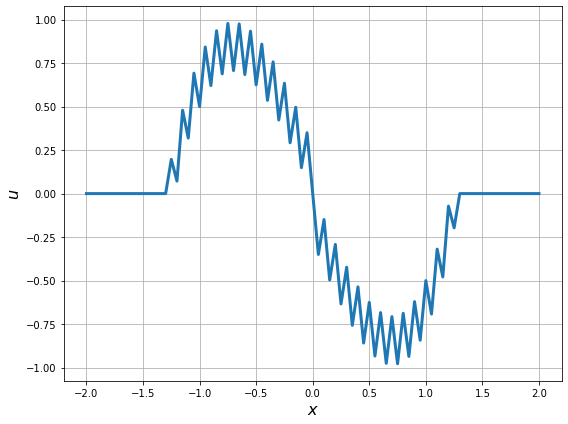

In [13]:
from matplotlib.pyplot import figure, show

ax = figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$u$', fontsize=16)
ax.plot(x_tests, u_tests, linewidth=3)
ax.grid()

show()

In [14]:
# from google.colab import drive
# drive.mount('/content/drive')

In [15]:
#Stability with Control Lyapunov Functions

from core.controllers import QPController
from numpy import array, dot, identity, linspace, meshgrid, zeros
from numpy.linalg import eigvals, norm

from core.dynamics import AffineDynamics, AffineQuadCLF, ScalarDynamics, SystemDynamics
from matplotlib.pyplot import figure, show
from core.util import arr_map

from core.controllers import FBLinController, LQRController
from core.systems import InvertedPendulum

def get_xs_us_grid(thetas_range, theta_dots_range, N_theta, N_theta_dot):
	# constructing state grid
	thetas = linspace(*thetas_range, N_theta + 1)
	theta_dots = linspace(*theta_dots_range, N_theta_dot + 1)
	theta_grid, theta_dot_grid = meshgrid(thetas, theta_dots)

	# constructing inputs in all directions
	us = array([-1, 1])
	
	# creating training data
	theta_lattice, theta_dot_lattice, u_lattice = meshgrid(thetas, theta_dots, us)
	xs = array([[theta, theta_dot] for theta_grid, theta_dot_grid in zip(theta_lattice, theta_dot_lattice) for theta_row, theta_dot_row in zip(theta_grid, theta_dot_grid) for theta, theta_dot in zip(theta_row, theta_dot_row)])
	us = array([[u] for u_grid in u_lattice for u_row in u_grid for u in u_row])
	
	return xs, us

def plot_surface(controller, theta_tests, theta_dot_tests):
	theta_test_grid, theta_dot_test_grid = meshgrid(theta_tests, theta_dot_tests)
	x_tests = array([[theta, theta_dot] for theta_row, theta_dot_row in zip(theta_test_grid, theta_dot_test_grid) for theta, theta_dot in zip(theta_row, theta_dot_row)])
	u_tests = []
	for x in x_tests:
	    try:
	        u = controller.process(controller.eval(x, 0))
	    except ValueError as e:
	        print(e, x)
	        u = array([0])
	    u_tests.append(u)
	u_tests = array(u_tests)

	fig = figure(figsize=(9, 4), tight_layout=True)
	ax = fig.add_subplot(1,2, 1, projection='3d')
	ax.plot_trisurf(*x_tests.T, u_tests[:, 0], cmap='jet', alpha=0.75)

	cross_section_inds = x_tests[:,0] == x_tests[30,0]
	ax = fig.add_subplot(1,2, 2,)
	ax.plot(x_tests[cross_section_inds, 1], u_tests[cross_section_inds, 0], '-')
	ax.plot(x_tests[cross_section_inds, 1], u_tests[cross_section_inds, 0], '.')

def plot_simulation(system, controller, x_0=array([0.8, 0.1]),
					T=20, num_steps=2000):
	# Simulation definitions
	ts = linspace(0, T, num_steps + 1)
    
	# Simulation
	xs_cl, us_cl_raw = system.simulate(x_0, controller, ts, processed=False)
	us_cl_infeasible = [u[0] is None for u in us_cl_raw]
	us_cl_infeasible = array([False] + us_cl_infeasible)
	us_cl = array([controller.process(u) for u in us_cl_raw])

	ax = figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$t$', fontsize=16)
	ax.plot(ts, xs_cl[:,0], '-', label='theta')
	ax.plot(ts, xs_cl[:,1], '-', label='theta dot')
	ax.plot(ts[1:], us_cl, '-', label='input')
	ax.plot(ts[us_cl_infeasible], zeros(sum(us_cl_infeasible)), 'o', label='infeasible')

	ax.legend(fontsize=16)
	ax.grid()

	ax = figure(figsize=(8, 6), tight_layout=True).add_subplot(1, 1, 1)
	ax.set_xlabel('$\\theta$', fontsize=16)
	ax.set_ylabel('$\dot \\theta$', fontsize=16)
	ax.plot(xs_cl[:,0], xs_cl[:,1], '-',)
	ax.grid()

def main(show_surface=False, show_trajectories=True):
	system = InvertedPendulum(m=0.7, l=0.7)
	system_est = InvertedPendulum(m=0.50, l=0.5)
	lyap = AffineQuadCLF.build_care(system, Q=identity(2), R=identity(1))
	lyap_est = AffineQuadCLF.build_care(system_est, Q=identity(2), R=identity(1))

	alpha = 1 / max(eigvals(lyap_est.P))

	# Linearizing Controller
	controller_linear = FBLinController(system_est, LQRController(system_est, lyap.P, R=identity(1)))
	# controller_linear = LQRController(system, lyap.P, R=identity(1))
 
 	# Nominal Controller Static Slacked
	controller = QPController(system_est, system.m)
	# controller.add_static_cost(identity(1))
	controller.add_regularizer(controller_linear, coeff=1)
	controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e3)

	# Robust Data-driven controller
	thetas_range = (-0.05, 1.0)
	theta_dots_range = (-0.2, 0.2)
	N_theta = 160
	N_theta_dot = 20
	xs, us = get_xs_us_grid(thetas_range, theta_dots_range, N_theta, N_theta_dot)
	ts = zeros(len(xs))
	x_dots = arr_map(system.eval_dot, xs, us, ts)

	m, l, g = system.params
	m_hat, l_hat, _ = system_est.params
	L_drift_error = abs(g * (l_hat - l) / (l_hat * l))
	L_act_error = 0.0
	# L_act_error =  abs(1 / (m * (l ** 2)) - 1 / (m_hat * (l_hat ** 2)))
	print(L_drift_error)
	print(L_act_error)
 	# Nominal Controller Static Slacked
	controller_robust = RobustQPController(system_est, xs, us, ts, x_dots, L_drift_error, L_act_error)
	# controller_robust.add_static_cost(identity(1))
	controller_robust.add_regularizer(controller_linear, coeff=1)
	controller_robust.add_robust_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 1e3)

	# Computing and plotting control surfaces
	if show_surface:
		theta_tests = linspace(*thetas_range, 2 * N_theta + 1)
		theta_dot_tests = linspace(*theta_dots_range, 2 * N_theta_dot + 1)
		plot_surface(controller, theta_tests, theta_dot_tests)
		# plot_surface(controller_linear, theta_tests, theta_dot_tests)
		plot_surface(controller_robust, theta_tests, theta_dot_tests)
		show()

	# Simulating and plotting trajectories
	if show_trajectories:
		# plot_simulation(system, controller_linear, x_0=array([2, 0.1]))
		plot_simulation(system, controller,)# x_0=array([2, 0.1]))
		plot_simulation(system, controller_robust,)# x_0=array([2, 0.1]))
		show()


5.605714285714285
0.0


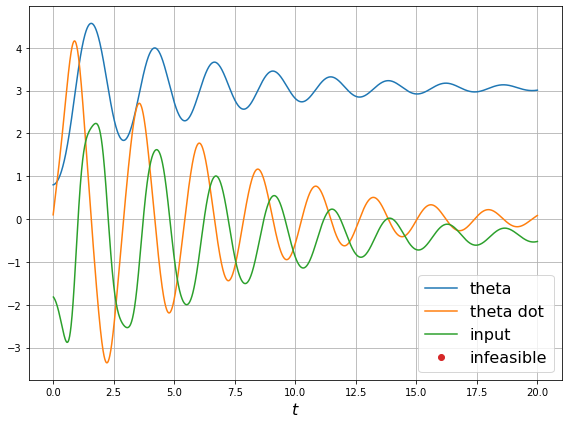

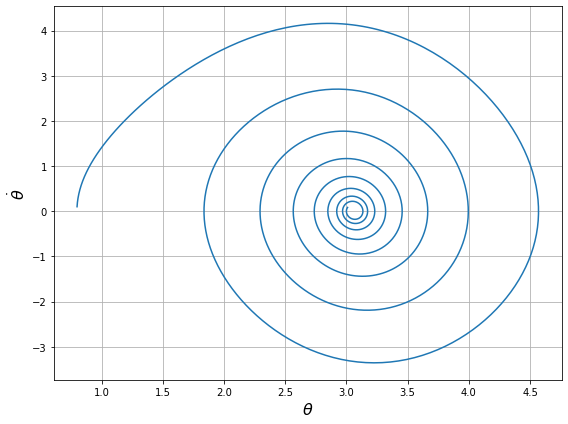

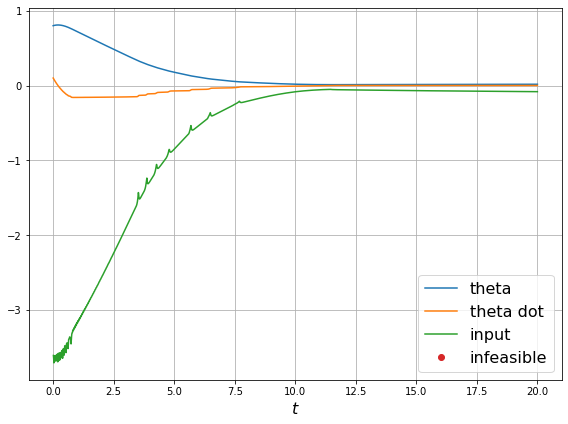

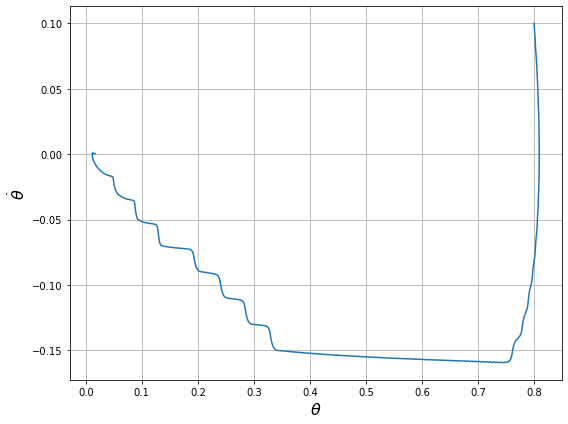

In [17]:
main()

In [19]:
#Safety with Control Barrier Functions
class SafetyFunction(AffineDynamics, ScalarDynamics):
    def __init__(self, inverted_pendulum, lyap, c):
        self.dynamics = inverted_pendulum
        self.lyap = lyap
        self.c = c

    def eval(self, x, t):
        return -(self.c - self.lyap.eval(x, t))
 
    def eval_grad(self, x, t):
        return self.lyap.eval_grad(x, t)

    def drift(self, x, t):
        return dot(self.eval_grad(x, t), self.dynamics.drift(x, t))
    
    def act(self, x, t):
        return dot(self.dynamics.act(x, t).T, self.eval_grad(x, t))

def main(show_surface=False, show_trajectories=True):
    system = InvertedPendulum(m=0.7, l=0.7)
    system_est = InvertedPendulum(m=0.50, l=0.5)
    lyap = AffineQuadCLF.build_care(system, Q=identity(2), R=identity(1))
    lyap_est = AffineQuadCLF.build_care(system_est, Q=identity(2), R=identity(1))
    barrier = SafetyFunction(system, lyap, .2)
    barrier_est = SafetyFunction(system_est, lyap_est, .2)

    alpha = 1 / max(eigvals(lyap_est.P))

    # Linearizing Controller
    controller_linear = FBLinController(system_est, LQRController(system_est, lyap.P, R=identity(1)))
    # controller_linear = LQRController(system, lyap.P, R=identity(1))

    # Nominal Controller Static Slacked
    controller = QPController(system_est, system.m)
    controller.add_static_cost(identity(1))
    # controller.add_regularizer(controller_linear, coeff=1)
    controller.add_stability_constraint(barrier_est, comp=lambda r: alpha * r, slacked=False, coeff = 1e3)

    # Robust Data-driven controller
    thetas_range = (-0.05, 0.2)
    theta_dots_range = (-0.2, 0.2)
    N_theta = 40
    N_theta_dot = 20
    xs, us = get_xs_us_grid(thetas_range, theta_dots_range, N_theta, N_theta_dot)
    ts = zeros(len(xs))
    x_dots = arr_map(system.eval_dot, xs, us, ts)

    m, l, g = system.params
    m_hat, l_hat, _ = system_est.params
    L_drift_error = abs(g * (l_hat - l) / (l_hat * l))
    L_act_error = 0.0
    # L_act_error =  abs(1 / (m * (l ** 2)) - 1 / (m_hat * (l_hat ** 2)))
    print(L_drift_error)
    print(L_act_error)
    # Nominal Controller Static Slacked
    controller_robust = RobustQPController(system_est, xs, us, ts, x_dots, L_drift_error, L_act_error)
    controller_robust.add_static_cost(identity(1))
    # controller_robust.add_regularizer(controller_linear, coeff=1)
    controller_robust.add_robust_safety_constraint(barrier_est, comp=lambda r: alpha * r, slacked=False, coeff = 1e3)
  
    # Computing and plotting control surfaces
    if show_surface:
        theta_tests = linspace(*thetas_range, 2 * N_theta + 1)
        theta_dot_tests = linspace(*theta_dots_range, 2 * N_theta_dot + 1)
        plot_surface(controller, theta_tests, theta_dot_tests)
        # plot_surface(controller_linear, theta_tests, theta_dot_tests)
        plot_surface(controller_robust, theta_tests, theta_dot_tests)
        show()

    # Simulating and plotting trajectories
    if show_trajectories:
        # plot_simulation(system, controller_linear, x_0=array([2, 0.1]))
        plot_simulation(system, controller,)# x_0=array([2, 0.1]))
        plot_simulation(system, controller_robust,)# x_0=array([2, 0.1]))
        show()

/Users/kimia/Library/Python/3.7/lib/python/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 3 times so far.

  warnings.warn(msg, UserWarning)


5.605714285714285
0.0


/Users/kimia/Library/Python/3.7/lib/python/site-packages/cvxpy/expressions/expression.py:593: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 4 times so far.

  warnings.warn(msg, UserWarning)


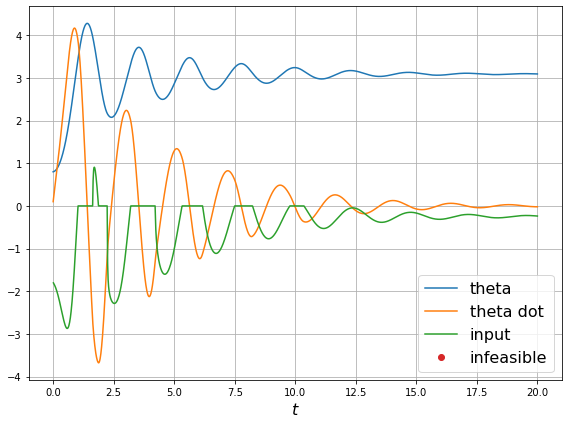

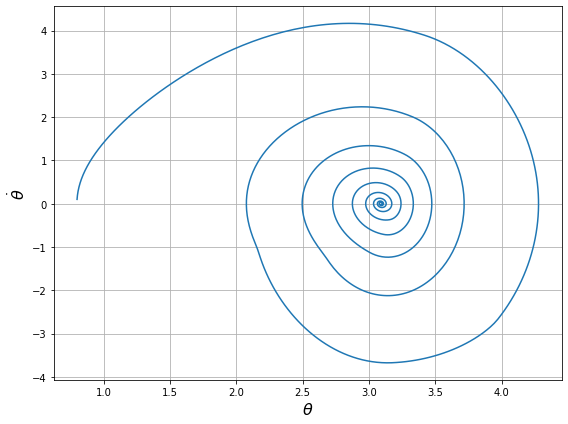

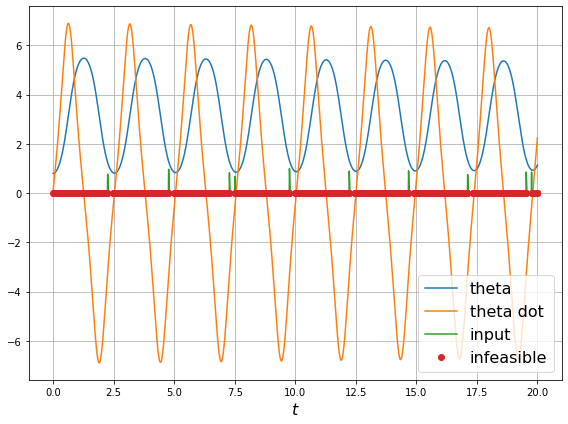

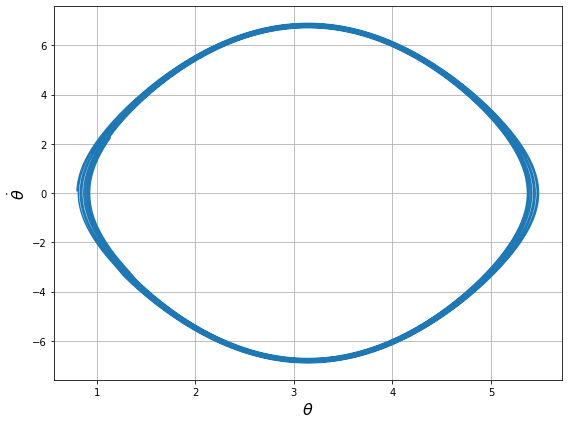

In [20]:
main()

In [21]:
system = InvertedPendulum(m=0.70, l=0.7)
system_est = InvertedPendulum(m=0.50, l=0.5)
lyap = AffineQuadCLF.build_care(system, Q=identity(2), R=identity(1))
lyap_est = AffineQuadCLF.build_care(system_est, Q=identity(2), R=identity(1))

alpha = 1 / max(eigvals(lyap_est.P))

# Linearizing Controller
controller_linear = FBLinController(system_est, LQRController(system, lyap.P, R=identity(1)))
# controller_linear = LQRController(system, lyap.P, R=identity(1))

# Nominal Controller Static Slacked
controller = QPController(system_est, system.m)
# controller.add_static_cost(identity(1))
controller.add_regularizer(controller_linear, coeff=1)
controller.add_stability_constraint(lyap_est, comp=lambda r: alpha * r, slacked=True, coeff = 5e3)

# Robust Data-driven controller
thetas_range = (-0.2, 0.2)
theta_dots_range = (-0.2, 0.2)
N_theta = 64
N_theta_dot = 20
xs, us = get_xs_us_grid(thetas_range, theta_dots_range, N_theta, N_theta_dot)
ts = zeros(len(xs))
x_dots = arr_map(system.eval_dot, xs, us, ts)

m, l, g = system.params
m_hat, l_hat, _ = system_est.params
L_drift_error = abs(g * (l_hat - l) / (l_hat * l))
L_act_error = 0.0
# L_act_error =  abs(1 / (m * (l ** 2)) - 1 / (m_hat * (l_hat ** 2)))
print(L_drift_error)
print(L_act_error)

# Nominal Controller Static Slacked
controller_robust = RobustQPController(system_est, xs, us, ts, x_dots, L_drift_error, L_act_error)
# controller_robust.add_static_cost(identity(1))
controller_robust.add_regularizer(controller_linear, coeff=1)
controller_robust.add_robust_safety_constraint(lyap_est, comp=lambda r: alpha * r, slacked=False, coeff = 5e3)

theta_tests = linspace(*thetas_range, 2 * N_theta + 1)
theta_dot_tests = linspace(*theta_dots_range, 2 * N_theta_dot + 1)
theta_test_grid, theta_dot_test_grid = meshgrid(theta_tests, theta_dot_tests)
x_tests = array([[theta, theta_dot] for theta_row, theta_dot_row in zip(theta_test_grid, theta_dot_test_grid) for theta, theta_dot in zip(theta_row, theta_dot_row)])
u_tests = []
for x in x_tests:
    try:
        u = controller_robust.process(controller_robust.eval(x, 0))
    except ValueError as e:
        print(e, x)
        u = array([0])
    u_tests.append(u)
u_tests = array(u_tests)

5.605714285714285
0.0


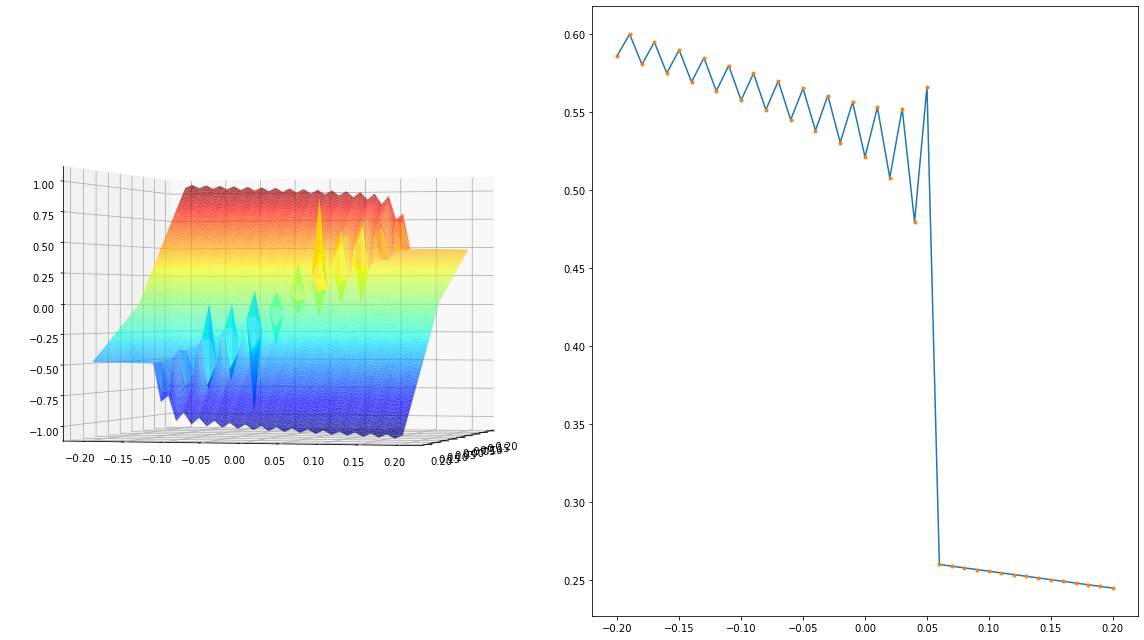

In [22]:
fig = figure(figsize=(16, 9), tight_layout=True)
ax = fig.add_subplot(1,2, 1, projection='3d')
ax.plot_trisurf(*x_tests.T, u_tests[:, 0], cmap='jet', alpha=0.75)
ax.view_init(elev = 0, azim = 15)

cross_section_inds = x_tests[:,0] == x_tests[30,0]
ax = fig.add_subplot(1,2, 2,)
ax.plot(x_tests[cross_section_inds, 1], u_tests[cross_section_inds, 0], '-')
ax.plot(x_tests[cross_section_inds, 1], u_tests[cross_section_inds, 0], '.')